# Hyper-parameter tuning using Bayesian optimization

Bayesian hyperparameter optimization: 
Builds a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.
(https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
(https://github.com/fmfn/BayesianOptimization/blob/master/examples/advanced-tour.ipynb)

## Functions needed to compute u*

In [1]:
import autograd.numpy as np
from scipy.linalg import fractional_matrix_power

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2

# Weight function returned by kernel Function
def weight(X, N_lst, r, eps):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    eps - gives perturbed kernel if eps != 0
    r - threshold in kernel function
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = N_lst.size
    W = np.zeros((N,N))
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist = np.linalg.norm(X[i]-X[j])**2
            if dist<=r:
                W[count_i][count_j] = 1
            W[count_i][count_j] += eps*np.exp(-dist/(r+eps)**2)

    np.fill_diagonal(W, 0)
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, eps, alpha, tau, r):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    '''
    N = N_lst.size
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    return fractional_matrix_power(1/tau**2*(L + tau**2*np.eye(N)), alpha)

# truncated version of Covariance defined in [3]-(62)
def Cov_truncated(X, N_lst, eps, alpha, tau, r, n_eig):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    r - threshold in kernel function
    n_eig - eigenvlue cutoff for truncated [3]-(62)
    '''
    N = N_lst.size
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    W = weight(X,N_lst,r,eps)
    D = np.diag(W.sum(axis=1))
    L = D - W
    LE, LV = np.linalg.eig(L)

    CE = 1/tau**2*(LE + tau**2)**alpha
    C = np.zeros((N,N))
    for k in range(n_eig):
        C = C + 1/CE[k]*np.outer(LV[:,k],(LV[:,k].T))
    return C

In [2]:
import ray
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch

# -----------Newton's Method----------------------------------

def misfit(u, N_lst, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    u - vector to find
    N_lst - list of indices used
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0.0
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        S = S - np.log(cap_psi(y[Z_j]*u[u_j][0],g))
    return S

def probit_min(X, N_lst, y, Z_p, u, g, alpha, tau, eps, rval):

    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    # Minimizer u for problem defined in [3]-(3)
    ret = 1/2*np.dot(u, np.matmul(C_inv,u)) + misfit(u, N_lst, y, Z_p, g)
    return ret

## Set up Data

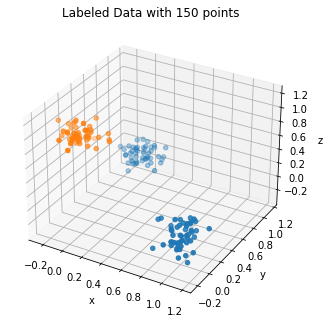

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N = N_each*n_cluster # Total number of points

mu, sigma = 0, 0.1 # mean and standard deviation
xs = np.random.normal(mu, sigma, N)
ys = np.random.normal(mu, sigma, N)
zs = np.random.normal(mu, sigma, N)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N_each] += 1; ys[N_each:2*N_each] += 1; zs[2*N_each:3*N_each] += 1
Data = np.array([xs,ys,zs]).T

u_dagger = np.append(np.ones(2*N_each), -1*np.ones(N_each))
Z_prime = np.array([0,20,40,50,60,80,100,130,140]) # Indices of labels
y = np.sign(u_dagger) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N_each], ys[:2*N_each], zs[:2*N_each], 'r')
ax.scatter(xs[2*N_each:3*N_each], ys[2*N_each:3*N_each], zs[2*N_each:3*N_each], 'b')
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

## Trainable Function for parameter

In [5]:
#defining trainable function that minimizes probit function
def trainable(config):
    maxiter = 50
    for __ in range(maxiter):
        u = np.random.normal(mu, sigma, N)
        result = probit_min(Data, N, y, Z_prime, u, config["g"], config["alpha"], 
                   config["tau"], config["eps"], config["rval"])
        tune.report(score = result)
        
        # Define the search space
config = {
    "g": tune.uniform(0,1.5),
    "alpha": tune.uniform(0, 6),
    "tau": tune.uniform(0, 6),
    "eps": tune.uniform(0, 1),
    "rval": tune.uniform(0, 1.5)
}

In [6]:
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(metric = "score", mode="min")
analysis = tune.run(trainable, config = config, search_alg=bayesopt, num_samples=5, verbose = 0)


2021-12-02 00:03:02,478	WARNING function_runner.py:563 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-12-02 00:03:02,497	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-12-02 00:03:02,497	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-12-02 00:03:02,501	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-12-02 00:03:02,503	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-12-02 00:03:02,507	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.


In [7]:
# Get a dataframe for the last reported results of all of the trials
df_results = analysis.results_df

# Get a dataframe for the max accuracy seen for each trial
df = analysis.dataframe(metric="score", mode="min")

# Get a dict mapping {trial logdir -> dataframes} for all trials in the experiment.
all_dataframes = analysis.trial_dataframes

# Get a list of trials
trials = analysis.trials

/opt/anaconda3/lib/python3.8/site-packages/ray/tune/analysis/experiment_analysis.py:565: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  warnings.warn(


In [8]:
analysis.get_best_config('score', 'min')

{'g': 1.2486639612006325,
 'alpha': 0.12350696577481468,
 'tau': 1.0909498032426037,
 'eps': 0.9699098521619943,
 'rval': 0.31850866601741423}

In [9]:
# Not bayesian
config = {
    "g": tune.uniform(0,1.5),
    "alpha": tune.uniform(0, 6),
    "tau": tune.uniform(0, 6),
    "eps": tune.uniform(0, 1.5),
    "rval": tune.uniform(0, 1.5)
}
analysis2 = tune.run(trainable, config = config, mode = 'min', metric = 'score', num_samples=5, verbose = 0)


In [10]:
best_trial = analysis2.best_trial  # Get best trial
best_config = analysis2.best_config  # Get best trial's hyperparameters
best_logdir = analysis2.best_logdir  # Get best trial's logdir
best_result = analysis2.best_result  # Get best trial's last results
best_result_df = analysis2.best_result_df  # Get best result as pandas dataframe

In [11]:
best_config

{'g': 0.4140913828206821,
 'alpha': 0.44416086812128763,
 'tau': 4.193217464856828,
 'eps': 0.28852282635609033,
 'rval': 1.3197892492225707}

# Now using bayesian optimization with kernel-flow methods

In [12]:
import scipy.optimize
import autograd.numpy as np
import autograd

# ------ EL method ------------------
# Array given by Fj in [3] - (12), (13)
def F_sum(N_lst, g, y, Z_p, u):
    '''
    N_lst - list of indices used
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    N = N_lst.size
    Fj = np.zeros(N)
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        basis=np.zeros(N);basis[u_j]=1.0
        Fj = Fj + y[Z_j]*psi(y[Z_j]*u[u_j], g)/cap_psi(y[Z_j]*u[u_j], g)*basis
    return Fj

# Function needed for fsolve using EL given in [3]-(2)
def u_ast_EL(X, N_lst, g, y, Z_p, alpha, tau, eps, rval, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    N = N_lst.size
    if x_0: x_0 = np.zeros((N,1))
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, eps, alpha, tau, rval, n_eig)
    def final(u):
    #     C = Cov(X, N, eps, alpha, tau, rval)
        return u - C@F_sum(N_lst, g, y, Z_p, u)
    return scipy.optimize.fsolve(final, x_0)

# ------- Newton's method --------------
def newton(f, x0, tol=10e-08, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    g = autograd.grad(f)
    h = autograd.hessian(f)

    x = x0
    for _ in range(maxiter):
        step = np.linalg.solve(h(x), -g(x))
        x = x + step
        if np.linalg.norm(step) < tol:
            break

    return x

# Returns u* using newton's method
def u_ast_Newt(X, N_lst, g, y, Z_p, alpha, tau, eps, rval, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, eps, alpha, tau, rval)
    def probit_min(u):
        # Minimizer u for problem defined in [3]-(3)
        return 1/2*np.dot(u, C_inv@u) + misfit(u, N_lst, y, Z_p, g)
    if x_0: x_0 = np.zeros(N_lst.size)
    return newton(probit_min, x_0)

In [13]:
# Using Kernel Flow method to approximate parameters

# Return randomly selected half data indices from N that includes half of
# labeled data
# Follows from [1]
def select_Nf(N, Z_prime):
    '''
    N - (int) number of elements
    Z_prime - indices of labeled data
    '''
    N_f = int((N-Z_prime.size)/2) # Must be <= N
    half_Z = int(Z_prime.size/2+1) # half of labels

    # Randomly selected indices N_f and N_c used for X,Y,Z
    # Always need to include Z' or else cant compute
    N_f_i = np.random.choice(N, N_f, replace=False)
    Z_half= np.random.choice(Z_prime, half_Z, replace=False)
    for z in Z_half:
        if z not in N_f_i:
            N_f_i = np.append(N_f_i, z)

    N_f = N_f_i.size
    return N_f_i, Z_half

# Follows rho expression given in [2]-(6)
def rho_EL(g, alpha, tau, eps, rval):
    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)

    uast = u_ast_EL(Data, N, g, y, Z_prime, alpha, tau, eps, rval)
    uast_tild = u_ast_EL(Data, N_f_i, g, y, Z_half, alpha, tau, eps, rval)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    for u_i, nf_i in enumerate(N_f_i):
        num += (uast_tild[u_i] - uast[nf_i])**2
        denom += uast[nf_i]**2
    return - num/denom

# Follows rho expression given in [2]-(6)
def rho_Newt(g, alpha, tau, eps, rval):
    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)

    uast = u_ast_Newt(Data, N, g, y, Z_prime, alpha, tau, eps, rval)
    uast_tild = u_ast_Newt(Data, N_f_i, g, y, Z_half, alpha, tau, eps, rval)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    for u_i, nf_i in enumerate(N_f_i):
        num += (uast_tild[u_i] - uast[nf_i])**2
        denom += uast[nf_i]**2
    return - num/denom

In [18]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

zeros = 1e-7
pbounds = {'g': (zeros,2), 'alpha':(zeros,3), 'tau':(zeros,4), 'eps':(zeros,2), 'rval':(zeros,1.5)}
optimizer_EL = BayesianOptimization(
    f=rho_EL,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
print("Optimizer for Euler-Lagrange equations")
# flip (rho) minimize --> (- rho) maximize
optimizer_EL.maximize(
    init_points=3,
    n_iter=10,
)

optimizer_Newt = BayesianOptimization(
    f=rho_Newt,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
print("Optimizer for Newton's Method")
# flip (rho) minimize --> (- rho) maximize
optimizer_Newt.maximize(
    init_points=3,
    n_iter=10,
)


Optimizer for Euler-Lagrange equations
|   iter    |  target   |   alpha   |    eps    |     g     |   rval    |    tau    |
-------------------------------------------------------------------------------------
|  1        | -4.482    |  1.251    |  1.441    |  0.000228 |  0.4535   |  0.587    |
|  2        | -0.9315   |  0.277    |  0.3725   |  0.6911   |  0.5952   |  2.155    |
|  3        | -1.078    |  1.258    |  1.37     |  0.4089   |  1.317    |  0.1096   |
|  4        | -2.763    |  2.341    |  1.897    |  0.4681   |  1.399    |  1.021    |
|  5        | -0.8027   |  0.3451   |  0.3744   |  0.5104   |  0.57     |  2.118    |
|  6        | -0.3259   |  0.106    |  1e-07    |  0.1605   |  0.585    |  2.729    |
|  7        | -0.2585   |  0.424    |  1e-07    |  1e-07    |  1.5      |  2.575    |
|  8        | -0.183    |  1.176    |  1e-07    |  1e-07    |  0.8561   |  3.311    |
|  9        | -0.138    |  0.226    |  0.7177   |  1e-07    |  1.338    |  3.818    |
|  10       | -

In [19]:
from time import perf_counter

if __name__ == "__main__":
# Initial Parameters
    eps = optimizer_EL.max['params']['eps']
    rval = optimizer_EL.max['params']['rval']
    tau = optimizer_EL.max['params']['tau']
    alpha = optimizer_EL.max['params']['alpha']
    g = optimizer_EL.max['params']['g']

    time_start = perf_counter()
    u_ast = u_ast_EL(Data, N, g, y, Z_prime, alpha, tau, eps, rval)
    print("Runtime for EL: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(np.sign(u_ast) - np.sign(u_dagger)))/(2*N)*100)
    print("Error for EL: " + str(pred_error))

    eps = optimizer_Newt.max['params']['eps']
    rval = optimizer_Newt.max['params']['rval']
    tau = optimizer_Newt.max['params']['tau']
    alpha = optimizer_Newt.max['params']['alpha']
    g = optimizer_Newt.max['params']['g']
    time_start = perf_counter()
    u_ast_newt = u_ast_Newt(Data, N, g, y, Z_prime, alpha, tau, eps, rval)
    print("Runtime for Newton's: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(np.sign(u_ast_newt) - np.sign(u_dagger)))/(2*N)*100)
    print("Error for Newton's: " + str(pred_error))

Runtime for EL: 0.722071360999962
Error for EL: 0.0
Runtime for Newton's: 11.155793981999977
Error for Newton's: 0.6666666666666667


In [20]:
optimizer_EL.max['params']

{'alpha': 2.489038046469184,
 'eps': 0.7127004954118672,
 'g': 1e-07,
 'rval': 0.05804649350117874,
 'tau': 4.0}

In [21]:
optimizer_Newt.max['params']

{'alpha': 1e-07,
 'eps': 1e-07,
 'g': 1e-07,
 'rval': 1.5,
 'tau': 2.2672005086247595}